# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
from skimage import transform,io
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import Input, Dense,  Flatten,  BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from tensorflow.keras import regularizers



Using TensorFlow backend.


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())


In [4]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
batch_size = 20#experiment with the batch size


In [6]:
classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channel = 3
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = imresize(image,(y,z))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    batch_data[folder,idx] = temp #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx] = temp
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
train_path = './Project_data/train'
val_path = './Project_data/val'


In [8]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras


from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

# Define model b
model_b = Sequential()
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,channel), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_b.add(Activation('relu'))
model_b.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_b.add(Dropout(0.25))

model_b.add(Flatten())
model_b.add(Dense(512, activation='relu'))
model_b.add(Dropout(0.5))
model_b.add(Dense(classes, activation='softmax'))

model_b.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 32)  27680     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 40, 40, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 40, 40, 64)    55360     
__________

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [10]:
batch_size=20


Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [12]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here

ES = EarlyStopping( monitor="val_loss",    min_delta=0.0001,    patience=12,    verbose=0,    mode="auto",    baseline=None)

callbacks_list = [checkpoint, LR, ES]


The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/trainEpoch 1/20
 ; batch size = 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/34 [===========================>..] - ETA: 12s - loss: 1.6261 - categorical_accuracy: 0.2344Batch:  34 Index: 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 214s 6s/step - loss: 1.6145 - categorical_accuracy: 0.2568 - val_loss: 1.5426 - val_categorical_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 1.54263, saving model to model_init_2020-08-2412_16_48.441776/model-00001-1.62131-0.23831-1.54263-0.41000.h5
Epoch 2/20
34/34 [==============================] - 28s 817ms/step - loss: 1.5095 - categorical_accuracy: 0.2941 - val_loss: 1.4630 - val_categorical_accuracy: 0.4400

Epoch 00002: val_loss improved from 1.54263 to 1.46304, saving model to model_init_2020-08-2412_16_48.441776/model-00002-1.50951-0.29412-1.46304-0.44000.h5
Epoch 3/20
34/34 [==============================] - 28s 817ms/step - loss: 1.5037 - categorical_accuracy: 0.3431 - val_loss: 1.4360 - val_categorical_accuracy: 0.4400

Epoch 00003: val_loss improved from 1.46304 to 1.43600, saving model to model_init_2020-08-2412_16_48.441776/model-00003-1.50365-0.34314-1.43600-0.44000.h5
Epoch 4/20
34/34 [===========================

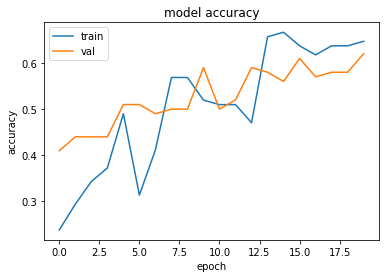

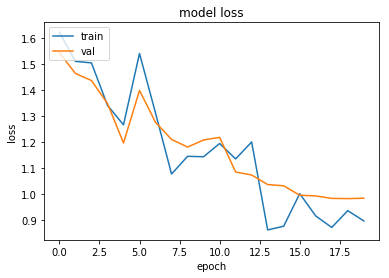

In [14]:
history=model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

plot_history(history)

<b><b>Changing Batch size to 30 Experiment 2</b></b>

In [15]:
train_generator = generator(train_path, train_doc, 30)
val_generator = generator(val_path, val_doc, 30)

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Source path =  ./Project_data/val ; batch size = 30
Source path =  ./Project_data/train ; batch size = 30
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Batch:  4 Index: 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 129s 4s/step - loss: 0.8128 - categorical_accuracy: 0.7000 - val_loss: 0.9271 - val_categorical_accuracy: 0.6636

Epoch 00001: val_loss improved from 0.98268 to 0.92710, saving model to model_init_2020-08-2412_16_48.441776/model-00001-0.84053-0.66523-0.92710-0.66364.h5
Epoch 2/20
34/34 [==============================] - 25s 745ms/step - loss: 0.8398 - categorical_accuracy: 0.6176 - val_loss: 0.9465 - val_categorical_accuracy: 0.6200

Epoch 00002: val_loss did not improve from 0.92710
Epoch 3/20
34/34 [==============================] - 25s 746ms/step - loss: 0.8968 - categorical_accuracy: 0.6471 - val_loss: 1.1359 - val_categorical_accuracy: 0.5800

Epoch 00003: val_loss did not improve from 0.92710

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 4/20
34/34 [==============================] - 25s 744ms/step - loss: 0.9129 - categorical_accuracy: 0.6275 - val_loss: 0.9560 - val_categorical_accuracy: 0.5600

Ep

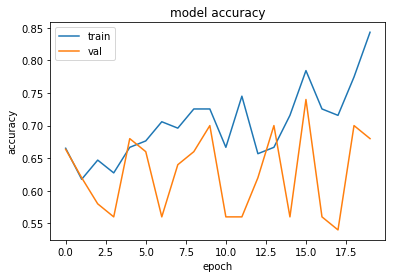

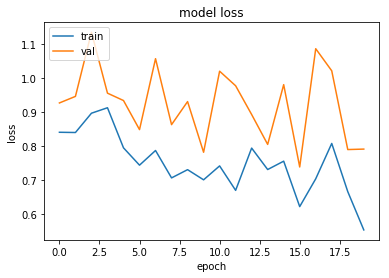

In [17]:
history=model_b.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)

<b><b>Experiment 3,experimenting with number of layers in the model</b></b>

In [18]:
nb_filters = [16,32,64,128]
nb_dense = [256, 128, 5]


# Input
input_shape=(30,120,120,3)

# Define model
model_final = Sequential()

model_final.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[2], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[3], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_final.add(Activation('relu'))
model_final.add(Dropout(0.25))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_final.add(Flatten())

model_final.add(Dense(nb_dense[0], activation='relu'))
model_final.add(Dropout(0.5))

model_final.add(Dense(nb_dense[1], activation='relu'))
model_final.add(Dropout(0.5))

#softmax layer
model_final.add(Dense(nb_dense[2], activation='softmax'))


In [19]:
optimiser = keras.optimizers.Adam(lr=0.0001) #write your optimizer
model_final.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_final.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 32)    128       
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 32)    0         
__________

In [20]:
batch_size = 40
num_epochs = 20
x=30
y=120
z=120
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
optimiser = keras.optimizers.Adam(lr=0.0001) #write your optimizer
model_final.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_final.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 32)    128       
_________________________________________________________________
activation_6 (Activation)    (None, 15, 60, 60, 32)    0         
__________

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 1/17 [>.............................] - ETA: 3:32 - loss: 3.8383 - categorical_accuracy: 0.1750Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 94s 6s/step - loss: 2.2898 - categorical_accuracy: 0.2088 - val_loss: 1.4655 - val_categorical_accuracy: 0.3600

Epoch 00001: val_loss did not improve from 0.73802
Epoch 2/20
17/17 [==============================] - 45s 3s/step - loss: 1.6113 - categorical_accuracy: 0.3018 - val_loss: 1.4949 - val_categorical_accuracy: 0.3167

Epoch 00002: val_loss did not improve from 0.73802
Epoch 3/20
17/17 [==============================] - 48s 3s/step - loss: 1.5954 - categorical_accuracy: 0.2991 - val_loss: 1.4820 - val_categorical_accuracy: 0.3833

Epoch 00003: val_loss did not improve from 0.73802

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 4/20
17/17 [==============================] - 42s 2s/step - loss: 1.5603 - categorical_accuracy: 0.2848 - val_loss: 1.4574 - val_categorical_accuracy: 0.5500

Epoch 00004: val_loss did not improve from 0.73802
Epoch 5/20
17/17 [==============================] - 41s 2s/step - 

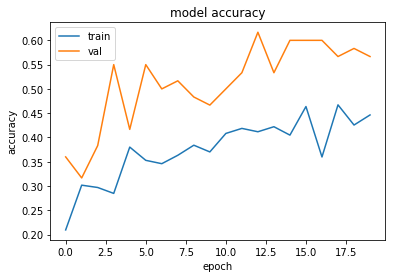

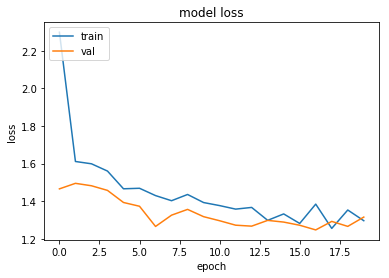

In [22]:
history=model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)

## Experimenting with neurons in dense layer

In [24]:
from keras.regularizers import l2
x=30
y=120
z=120
nb_filters = [16,32,64]
nb_dense = [ 500, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0],kernel_size=(3,3,3),input_shape=input_shape,padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1],kernel_size=(3,3,3),padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2],kernel_size=(3,3,3),padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

# model.add(Conv3D(nb_filters[3],kernel_size=(2,2,2),padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.25))

#model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())
model.add(Dropout(0.25))
# model.add(Dense(nb_dense[0], activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[1], activation='softmax'))

In [25]:
optimiser = keras.optimizers.Adam(lr=0.0001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_14 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 60, 60, 32)    128       
__________

In [26]:
batch_size=40
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Source path =  ./Project_data/val ; batch size = 40
Source path =  ./Project_data/train ; batch size = 40
Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/17 [==>...........................] - ETA: 1:43 - loss: 4.6881 - categorical_accuracy: 0.1875Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 90s 5s/step - loss: 3.4093 - categorical_accuracy: 0.3750 - val_loss: 1.7390 - val_categorical_accuracy: 0.5600

Epoch 00001: val_loss did not improve from 0.73802
Epoch 2/20
17/17 [==============================] - 49s 3s/step - loss: 1.4322 - categorical_accuracy: 0.6394 - val_loss: 1.5050 - val_categorical_accuracy: 0.5833

Epoch 00002: val_loss did not improve from 0.73802
Epoch 3/20
17/17 [==============================] - 46s 3s/step - loss: 1.1816 - categorical_accuracy: 0.6316 - val_loss: 1.2904 - val_categorical_accuracy: 0.4333

Epoch 00003: val_loss did not improve from 0.73802
Epoch 4/20
17/17 [==============================] - 42s 2s/step - loss: 0.7655 - categorical_accuracy: 0.7276 - val_loss: 0.9481 - val_categorical_accuracy: 0.6500

Epoch 00004: val_loss did not improve from 0.73802
Epoch 5/20
17/17 [==============================] - 40s 2s/step - loss: 0.6203 - categorical_accuracy: 0.7671 - val_loss: 1.1443 - val_categorical_

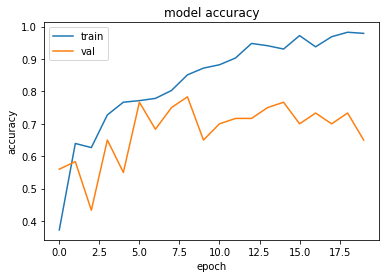

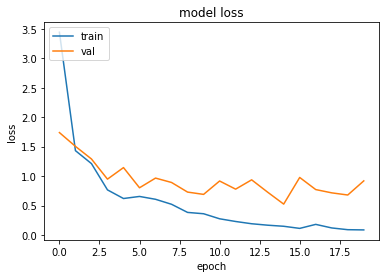

In [27]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)

## Adding L2 regularization

In [28]:
from keras.regularizers import l2
x=30
y=120
z=120
nb_filters = [16,32,64,128]
nb_dense = [1000, 500, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0],kernel_size=(3,3,3),input_shape=input_shape,padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1],kernel_size=(3,3,3),padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2],kernel_size=(3,3,3),padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3],kernel_size=(3,3,3),padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [29]:
optimiser = keras.optimizers.Adam(lr=0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_17 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 15, 60, 60, 32)    128       
__________

In [30]:
batch_size = 40
num_epochs = 20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Source path =  ./Project_data/valSource path =  ./Project_data/train ; batch size = 40
Epoch 1/20 ; batch size = 40



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/17 [==>...........................] - ETA: 1:50 - loss: 31.1488 - categorical_accuracy: 0.1500

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 90s 5s/step - loss: 28.3361 - categorical_accuracy: 0.2244 - val_loss: 21.5480 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss did not improve from 0.52399
Epoch 2/20
17/17 [==============================] - 48s 3s/step - loss: 19.8125 - categorical_accuracy: 0.3146 - val_loss: 17.7832 - val_categorical_accuracy: 0.3667

Epoch 00002: val_loss did not improve from 0.52399
Epoch 3/20
17/17 [==============================] - 47s 3s/step - loss: 16.3077 - categorical_accuracy: 0.3899 - val_loss: 14.6665 - val_categorical_accuracy: 0.4500

Epoch 00003: val_loss did not improve from 0.52399
Epoch 4/20
17/17 [==============================] - 40s 2s/step - loss: 13.5950 - categorical_accuracy: 0.3901 - val_loss: 12.2776 - val_categorical_accuracy: 0.4333

Epoch 00004: val_loss did not improve from 0.52399
Epoch 5/20
17/17 [==============================] - 41s 2s/step - loss: 11.3990 - categorical_accuracy: 0.4797 - val_loss: 10.3258 - val_ca

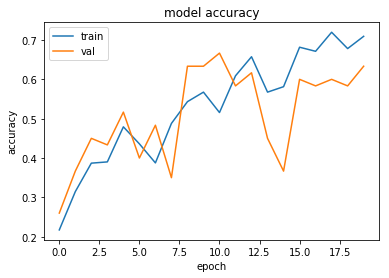

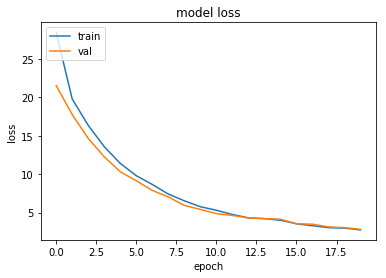

In [31]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)

In [32]:
batch_size = 40
num_epochs = 30
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Source path =  ./Project_data/valSource path =  Epoch 1/30
 ./Project_data/train ; batch size = 40
; batch size = 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 1/17 [>.............................] - ETA: 2:09 - loss: 2.8304 - categorical_accuracy: 0.7000Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 89s 5s/step - loss: 2.5269 - categorical_accuracy: 0.7607 - val_loss: 2.6640 - val_categorical_accuracy: 0.6200

Epoch 00001: val_loss did not improve from 0.52399
Epoch 2/30
17/17 [==============================] - 50s 3s/step - loss: 2.2958 - categorical_accuracy: 0.7801 - val_loss: 2.5180 - val_categorical_accuracy: 0.6500

Epoch 00002: val_loss did not improve from 0.52399
Epoch 3/30
17/17 [==============================] - 45s 3s/step - loss: 2.1414 - categorical_accuracy: 0.7927 - val_loss: 2.2773 - val_categorical_accuracy: 0.6667

Epoch 00003: val_loss did not improve from 0.52399
Epoch 4/30
17/17 [==============================] - 42s 2s/step - loss: 2.1675 - categorical_accuracy: 0.7895 - val_loss: 2.2224 - val_categorical_accuracy: 0.7500

Epoch 00004: val_loss did not improve from 0.52399
Epoch 5/30
17/17 [==============================] - 40s 2s/step - loss: 2.1438 - categorical_accuracy: 0.7770 - val_loss: 2.2419 - val_categorical_

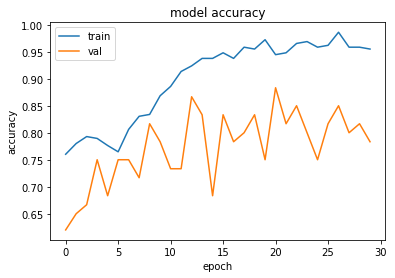

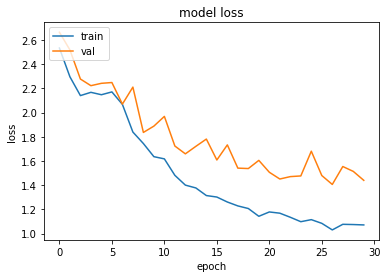

In [33]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)

In [34]:
from keras.regularizers import l2
x=30
y=120
z=120
nb_filters = [16,32,64,128]
nb_dense = [500, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0],kernel_size=(3,3,3),input_shape=input_shape,padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1],kernel_size=(3,3,3),padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2],kernel_size=(3,3,3),padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3],kernel_size=(1,3,3),padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())
model.add(Dropout(0.25))
# model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.05)))
# model.add(Dropout(0.5))

model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[1], activation='softmax'))

In [35]:
batch_size = 40
num_epochs = 20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
optimiser = keras.optimizers.Adam(lr=0.0001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_18 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_21 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 15, 60, 60, 32)    128       
__________

Source path =  ./Project_data/val ; batch size = 40Source path =  ./Project_data/train ; batch size = 40

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/17 [==>...........................] - ETA: 1:39 - loss: 13.6083 - categorical_accuracy: 0.2125Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 91s 5s/step - loss: 13.1430 - categorical_accuracy: 0.2704 - val_loss: 10.5367 - val_categorical_accuracy: 0.4500

Epoch 00001: val_loss did not improve from 0.52399
Epoch 2/20
17/17 [==============================] - 47s 3s/step - loss: 11.0596 - categorical_accuracy: 0.3964 - val_loss: 10.2859 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss did not improve from 0.52399
Epoch 3/20
17/17 [==============================] - 47s 3s/step - loss: 10.6967 - categorical_accuracy: 0.3945 - val_loss: 10.1255 - val_categorical_accuracy: 0.5500

Epoch 00003: val_loss did not improve from 0.52399
Epoch 4/20
17/17 [==============================] - 41s 2s/step - loss: 10.2672 - categorical_accuracy: 0.4644 - val_loss: 10.0870 - val_categorical_accuracy: 0.4833

Epoch 00004: val_loss did not improve from 0.52399
Epoch 5/20
17/17 [==============================] - 41s 2s/step - loss: 9.9363 - categorical_accuracy: 0.5686 - val_loss: 9.8378 - val_cate

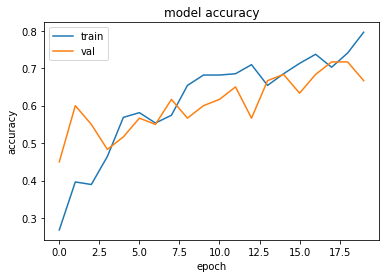

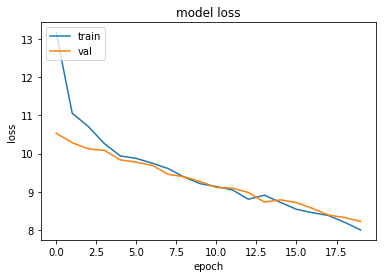

In [37]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)

## Increasing batch size

In [38]:
batch_size = 50
num_epochs = 20
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)   
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/trainEpoch 1/20
 ; batch size = 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 14s - loss: 7.8894 - categorical_accuracy: 0.8217Batch:  14 Index: 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 100s 7s/step - loss: 7.8721 - categorical_accuracy: 0.8270 - val_loss: 8.1087 - val_categorical_accuracy: 0.6900

Epoch 00001: val_loss did not improve from 0.52399
Epoch 2/20
14/14 [==============================] - 24s 2s/step - loss: 7.7164 - categorical_accuracy: 0.8681 - val_loss: 8.0517 - val_categorical_accuracy: 0.6900

Epoch 00002: val_loss did not improve from 0.52399
Epoch 3/20
14/14 [==============================] - 25s 2s/step - loss: 7.7180 - categorical_accuracy: 0.8242 - val_loss: 8.0225 - val_categorical_accuracy: 0.6800

Epoch 00003: val_loss did not improve from 0.52399
Epoch 4/20
14/14 [==============================] - 25s 2s/step - loss: 7.8040 - categorical_accuracy: 0.7692 - val_loss: 7.9299 - val_categorical_accuracy: 0.7200

Epoch 00004: val_loss did not improve from 0.52399
Epoch 5/20
14/14 [==============================] - 26s 2s/step - loss: 7.6555 - categorical_accuracy: 0.7912 - val_loss: 7.8099 - val_categorical

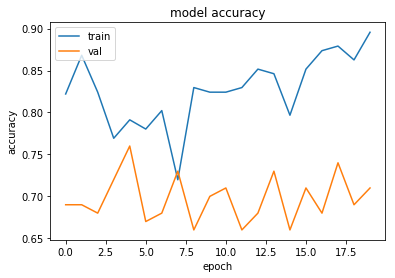

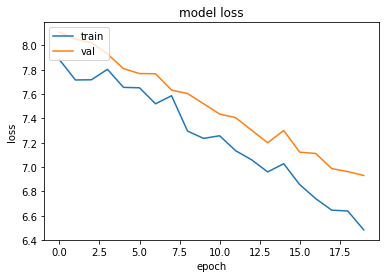

In [39]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)

In [40]:
from keras.regularizers import l2
x=30
y=120
z=120
nb_filters = [16,32,64,128]
nb_dense = [1000,500, 5]

# Input
input_shape=(30,120,120,3)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0],kernel_size=(3,3,3),input_shape=input_shape,padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1],kernel_size=(3,3,3),padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2],kernel_size=(3,3,3),padding='same'))

model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3],kernel_size=(3,3,3),padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(nb_dense[0], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(nb_dense[1], activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

In [41]:
batch_size = 40
num_epochs = 30
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [42]:
optimiser = keras.optimizers.Adam(lr=0.0001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_25 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 15, 60, 60, 32)    128       
__________

Source path = Source path =  ./Project_data/train ; batch size = 40
Epoch 1/30
 ./Project_data/val ; batch size = 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/17 [==>...........................] - ETA: 1:46 - loss: 28.6160 - categorical_accuracy: 0.1500Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


17/17 [==============================] - 91s 5s/step - loss: 27.5550 - categorical_accuracy: 0.2385 - val_loss: 24.9342 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss did not improve from 0.52399
Epoch 2/30
17/17 [==============================] - 50s 3s/step - loss: 25.6260 - categorical_accuracy: 0.3043 - val_loss: 24.6591 - val_categorical_accuracy: 0.3333

Epoch 00002: val_loss did not improve from 0.52399
Epoch 3/30
17/17 [==============================] - 45s 3s/step - loss: 24.8172 - categorical_accuracy: 0.3494 - val_loss: 24.1259 - val_categorical_accuracy: 0.5333

Epoch 00003: val_loss did not improve from 0.52399
Epoch 4/30
17/17 [==============================] - 42s 2s/step - loss: 24.3040 - categorical_accuracy: 0.4149 - val_loss: 23.7414 - val_categorical_accuracy: 0.5833

Epoch 00004: val_loss did not improve from 0.52399
Epoch 5/30
17/17 [==============================] - 40s 2s/step - loss: 23.8781 - categorical_accuracy: 0.4032 - val_loss: 23.4723 - val_ca

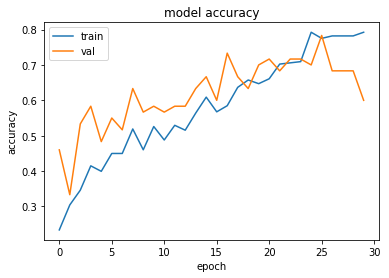

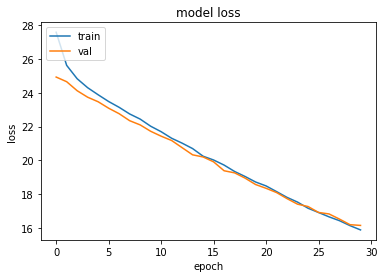

In [43]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)

In [46]:
batch_size = 50
num_epochs = 30
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Source path =  ./Project_data/val ; batch size = 50
Source path =  ./Project_data/train ; batch size =Epoch 1/30
 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


12/14 [========================>.....] - ETA: 14s - loss: 15.6055 - categorical_accuracy: 0.8333Batch:  14 Index: 50


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


14/14 [==============================] - 99s 7s/step - loss: 15.5941 - categorical_accuracy: 0.8338 - val_loss: 15.7098 - val_categorical_accuracy: 0.7500

Epoch 00001: val_loss did not improve from 0.52399
Epoch 2/30
14/14 [==============================] - 29s 2s/step - loss: 15.3067 - categorical_accuracy: 0.8681 - val_loss: 15.5479 - val_categorical_accuracy: 0.7600

Epoch 00002: val_loss did not improve from 0.52399
Epoch 3/30
14/14 [==============================] - 31s 2s/step - loss: 15.1815 - categorical_accuracy: 0.8297 - val_loss: 15.4263 - val_categorical_accuracy: 0.7200

Epoch 00003: val_loss did not improve from 0.52399
Epoch 4/30
14/14 [==============================] - 30s 2s/step - loss: 15.0881 - categorical_accuracy: 0.8242 - val_loss: 15.1308 - val_categorical_accuracy: 0.7800

Epoch 00004: val_loss did not improve from 0.52399
Epoch 5/30
14/14 [==============================] - 28s 2s/step - loss: 14.7922 - categorical_accuracy: 0.8516 - val_loss: 14.9412 - val_ca

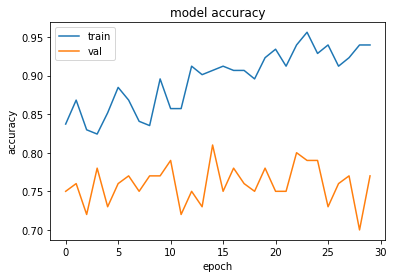

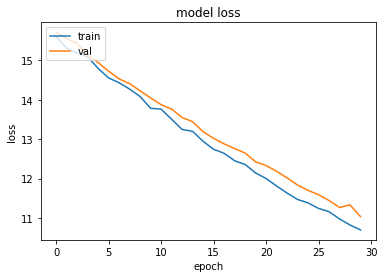

In [47]:
history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plot_history(history)